In [11]:
PROJECT_ROOT = "/home/vladislav/experiments/texts-similarity"

In [12]:
import sys  
sys.path.insert(1, PROJECT_ROOT)

In [13]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import DistanceMetric

from datasets.siamese.siamese_dataset import SiameseNetworkDataset
from determining.random_settings import determine_random
from losses.contrastive_loss import ContrastiveLoss
from statistic.metrics import Metrics

In [14]:
def get_args():
    parser = argparse.ArgumentParser(
    description='PyTorch Siamese network Example')
    parser.add_argument(
        '--batch-size',
        type=int,
        default=64,
        metavar='N',
        help='input batch size for training (default: 64)'
    )
    parser.add_argument(
        '--test-batch-size',
        type=int,
        default=1,
        metavar='N',
        help='input batch size for testing (default: 1)'
    )
    parser.add_argument(
        '--epochs',
        type=int,
        default=100,
        metavar='N',
        help='number of epochs to train (default: 100)'
    )
    parser.add_argument(
        '--lr',
        type=float,
        default=0.01,
        metavar='LR',
        help='learning rate (default: 0.01)'
    )
    parser.add_argument(
        '--gamma',
        type=float,
        default=0.001,
        metavar='M',
        help='Learning rate step gamma (default: 0.001)'
    )
    parser.add_argument(
        '--no-cuda',
        action='store_true',
        default=False,
        help='disables CUDA training'
    )
    parser.add_argument(
        '--no-mps',
        action='store_true',
        default=False,
        help='disables macOS GPU training'
    )
    parser.add_argument(
        '--dry-run',
        action='store_true',
        default=False,
        help='quickly check a single pass'
    )
    parser.add_argument(
        '--seed',
        type=int,
        default=134,
        metavar='S',
        help='random seed (default: 1)'
    )
    parser.add_argument(
        '--log-interval',
        type=int,
        default=10,
        metavar='N',
        help='how many batches to wait before logging training status'
    )
    parser.add_argument(
        '--save-model',
        action='store_true',
        default=False,
        help='For Saving the current Model'
    )
    parser.add_argument(
        '--n-splits',
        type=int,
        default=5,
        metavar='N',
        help='Number of splits for crossvalidation (default: 5)'
    )
    
    args = parser.parse_args([])
    return args
    

In [15]:
# create the Siamese Neural Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_stat: list[Metrics] = list()
        self.test_stat: Metrics | None = None

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        return output1, output2


In [16]:
def train(args, model: SiameseNetwork, device, train_loader: DataLoader, optimizer, epoch: int) -> None:
    model.train()
    criterion = ContrastiveLoss()
    
    loss: Tensor | None = None
    
    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader, 0):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        output1, output2 = model(images_1, images_2)
        loss = criterion(output1, output2, targets)
        loss.backward()
        optimizer.step()
        if args.dry_run:
            print(f'Epoch: {epoch} \tLoss: {loss.item()}')
            break
            

In [17]:
def test(model, device, test_loader: DataLoader) -> Metrics:
    model.eval()
    criterion = ContrastiveLoss()

    y_true = []
    y_pred = []
    loss: Tensor | None = None

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            output1, output2 = model(images_1, images_2)
            loss = criterion(output1, output2, targets)
            x1 = output1.detach().detach().cpu().numpy()
            x2 = output2.detach().detach().cpu().numpy()
            x1 = [x1[0] / np.linalg.norm(x1) if np.linalg.norm(x1) != 0 else x1[0]]
            x2 = [x2[0] / np.linalg.norm(x2) if np.linalg.norm(x2) != 0 else x2[0]]
            print(1 - DistanceMetric.get_metric('euclidean').pairwise(x1, x2)[0][0])
            pred = 0 if (1 - DistanceMetric.get_metric('euclidean').pairwise(x1, x2)[0][0]) >= 0.5 else 1

            y_pred.append(pred)
            y_true.extend(targets.detach().cpu().numpy())

    return Metrics(y_true=torch.from_numpy(np.array(y_true)), y_pred=torch.from_numpy(np.array(y_pred)), loss=loss.item())


In [19]:
args = get_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

determine_random(args.seed)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

print(f"Running on {device}")


Running on cuda


In [20]:
transformation = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

total_dataset = SiameseNetworkDataset(
    image_folder_dataset=datasets.ImageFolder(
        root=f"{PROJECT_ROOT}/datasets/siamese/data/"),
    transform=transformation)

test_metrics = []
history = {}


In [ ]:
for split_idx, (train_idx, test_idx) in enumerate(KFold(n_splits=args.n_splits, shuffle=True).split(total_dataset)):
    print(f"Running split #{split_idx + 1}")
    print(train_idx)
    print(test_idx)
    print("****")
    train_loader = DataLoader(
        total_dataset,
        sampler=SubsetRandomSampler(train_idx),
        **train_kwargs
    )

    test_loader = DataLoader(
        total_dataset,
        sampler=SubsetRandomSampler(test_idx),
        **test_kwargs,
    )

    model = SiameseNetwork().to(device)
    print(model)
    print()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=args.gamma)

    train_metrics = []
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        train_metrics.append(test(model, device, test_loader))
        scheduler.step()
    history[split_idx] = train_metrics
    test_metrics.append(test(model, device, test_loader))
    

Running split #1
[  0   1   2   4   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  27  28  31  32  33  34  35  36  37  38  39  40  44
  46  48  49  50  53  55  56  57  58  59  60  62  63  64  65  66  68  69
  70  71  72  73  74  75  76  77  78  79  81  82  85  86  87  88  89  90
  92  93  94  95  96  97  98 100 102 103 104 105 107 108 109 110 111 115
 117 119 121 122 123 124 125 126 128 129 130 132 133 135 136 137 138 139
 140 141 142 143 144 145 146 148 150 151 152 153 154 155 156 157 158 159
 160 162 163 164 165 166 167 168 172 173 174 175 177 178 180 181 182 183
 184 185 186 187 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 207 208 209 210 213 214 215 217 218 219 220 221 222 223 224
 225 226 227 228 229 231 232 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 252 253 255 257 258 260 262 263 264 265 266 267
 268 269 271 272 273 274 275 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 294 295 296 2

Split #1:
	Precision: 0.438
	Recall: 0.925
	F1 Score: 0.594


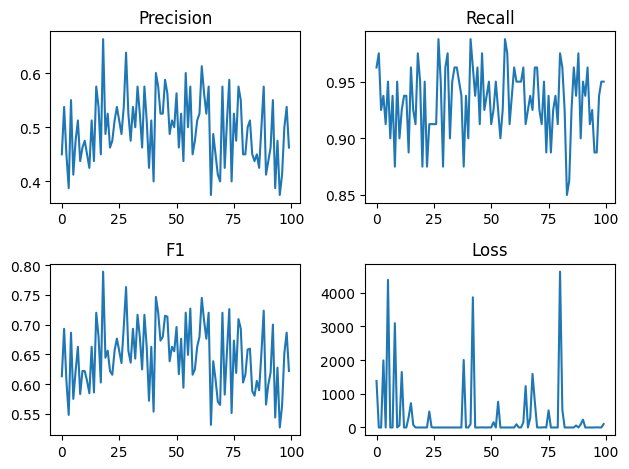

Split #2:
	Precision: 0.525
	Recall: 0.850
	F1 Score: 0.649


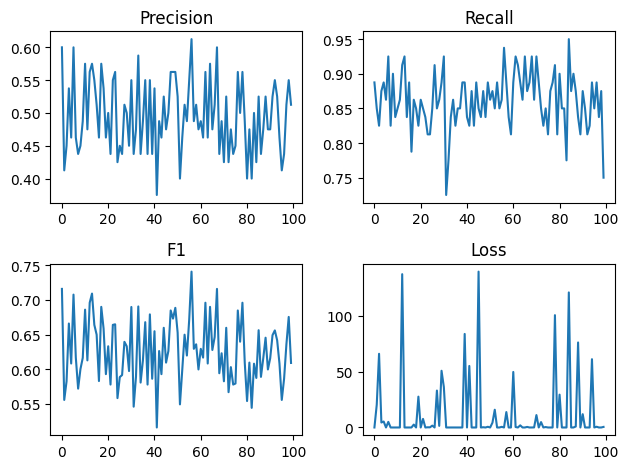

Split #3:
	Precision: 0.412
	Recall: 0.900
	F1 Score: 0.566


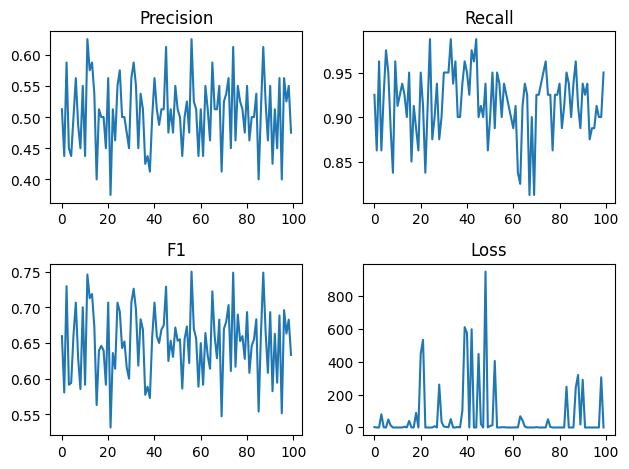

Split #4:
	Precision: 0.575
	Recall: 0.963
	F1 Score: 0.720


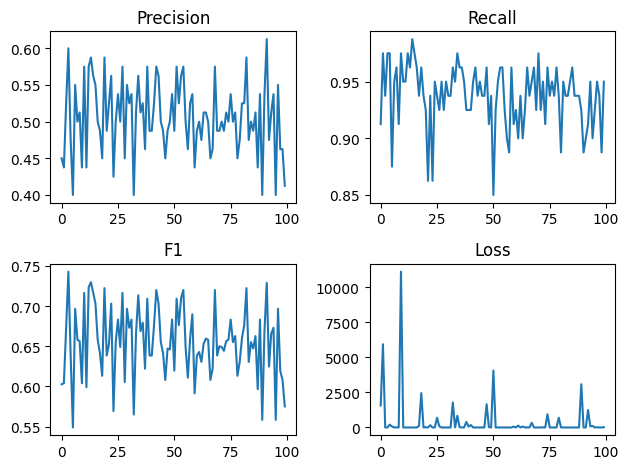

Split #5:
	Precision: 0.500
	Recall: 0.887
	F1 Score: 0.640


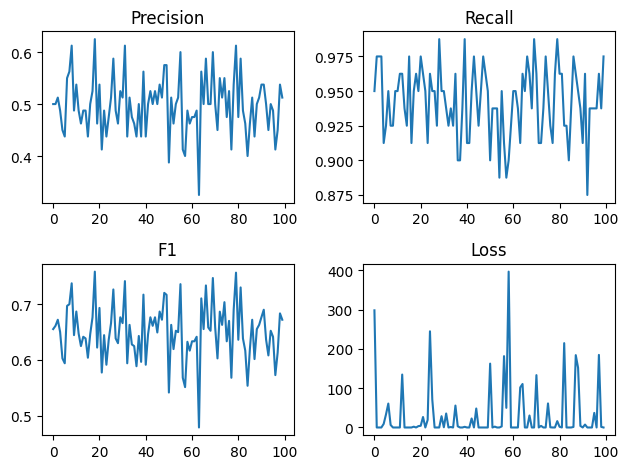

In [53]:
for split_idx in history.keys():
    train_metrics = history[split_idx]
    X = np.arange(0, len(train_metrics), 1)
    
    Y1 = [i.precision for i in train_metrics]
    Y2 = [i.recall for i in train_metrics]
    Y3 = [i.f1 for i in train_metrics]
    Y4 = [i.loss for i in train_metrics]
    
    figure, axis = plt.subplots(2, 2)
    
    axis[0, 0].plot(X, Y1)
    axis[0, 0].set_title("Precision")
    
    axis[0, 1].plot(X, Y2)
    axis[0, 1].set_title("Recall")
    
    axis[1, 0].plot(X, Y3)
    axis[1, 0].set_title("F1")
    
    axis[1, 1].plot(X, Y4)
    axis[1, 1].set_title("Loss")
    
    test_stat = test_metrics[split_idx]
    
    print(f"Split #{split_idx + 1}:")
    print(f'\tPrecision: {test_stat.precision:.3f}')
    print(f'\tRecall: {test_stat.recall:.3f}')
    print(f'\tF1 Score: {test_stat.f1:.3f}')
    figure.tight_layout()
    plt.show()
    

In [71]:
avg_precision = 0
avg_recall = 0
avg_f1 = 0
for metric in test_metrics:
    avg_precision += metric.precision
    avg_recall += metric.recall
    avg_f1 += metric.f1
print(f'AVG Precision: {avg_precision / len(test_metrics):.3f}')
print(f'AVG Recall: {avg_recall / len(test_metrics):.3f}')
print(f'AVG F1 Score: {avg_f1 / len(test_metrics):.3f}')


AVG Precision: 0.500
AVG Recall: 0.000
AVG F1 Score: 0.000


In [3]:
PROJECT_ROOT = "/home/vladislav/experiments/texts-similarity"

import sys

sys.path.insert(1, PROJECT_ROOT)

import argparse

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import DistanceMetric
from transformers import GPT2Model, GPT2Tokenizer

from datasets.siamese.text_dataset import TextDataset
from determining.random_settings import determine_random
from losses.contrastive_loss import ContrastiveLoss
from statistic.metrics import Metrics

/home/vladislav/experiments/texts-similarity/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def get_args():
    parser = argparse.ArgumentParser(
        description='PyTorch Siamese network Example')
    parser.add_argument(
        '--batch-size',
        type=int,
        default=64,
        metavar='N',
        help='input batch size for training (default: 64)'
    )
    parser.add_argument(
        '--test-batch-size',
        type=int,
        default=1,
        metavar='N',
        help='input batch size for testing (default: 1)'
    )
    parser.add_argument(
        '--epochs',
        type=int,
        default=100,
        metavar='N',
        help='number of epochs to train (default: 100)'
    )
    parser.add_argument(
        '--lr',
        type=float,
        default=0.01,
        metavar='LR',
        help='learning rate (default: 0.01)'
    )
    parser.add_argument(
        '--gamma',
        type=float,
        default=0.001,
        metavar='M',
        help='Learning rate step gamma (default: 0.001)'
    )
    parser.add_argument(
        '--no-cuda',
        action='store_true',
        default=False,
        help='disables CUDA training'
    )
    parser.add_argument(
        '--no-mps',
        action='store_true',
        default=False,
        help='disables macOS GPU training'
    )
    parser.add_argument(
        '--dry-run',
        action='store_true',
        default=False,
        help='quickly check a single pass'
    )
    parser.add_argument(
        '--seed',
        type=int,
        default=134,
        metavar='S',
        help='random seed (default: 1)'
    )
    parser.add_argument(
        '--log-interval',
        type=int,
        default=10,
        metavar='N',
        help='how many batches to wait before logging training status'
    )
    parser.add_argument(
        '--save-model',
        action='store_true',
        default=False,
        help='For Saving the current Model'
    )
    parser.add_argument(
        '--n-splits',
        type=int,
        default=5,
        metavar='N',
        help='Number of splits for crossvalidation (default: 5)'
    )

    args = parser.parse_args([])
    return args

from sklearn.metrics.pairwise import cosine_similarity
def test(device, test_loader: DataLoader) -> Metrics:
    gpt_model = GPT2Model.from_pretrained('openai-community/gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2')
    gpt_model.to(device)

    gpt_model.eval()

    y_true = []
    y_pred = []

    with (torch.no_grad()):
        for (text1, text2, similarity) in test_loader:
            text1, text2, similarity = (
                tokenizer(text1, return_tensors='pt').to(device),
                tokenizer(text2, return_tensors='pt').to(device),
                similarity.to(device)
            )
            output1 = gpt_model(**text1)[0].mean(1)
            output2 = gpt_model(**text2)[0].mean(1)
            x1 = output1.detach().detach().cpu().numpy()
            x2 = output2.detach().detach().cpu().numpy()
            pred = 1 if (cosine_similarity(x1, x2)[0][0]) > 0.5 else 0
            y_pred.append(pred)
            y_true.extend(similarity.detach().cpu().numpy())

    return Metrics(y_true=torch.from_numpy(np.array(y_true)), y_pred=torch.from_numpy(np.array(y_pred)))


args = get_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

determine_random(args.seed)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

print(f"Running on {device}")

total_dataset = TextDataset(delimiter=',', encoding='windows-1251',
                            csv_file=f"{PROJECT_ROOT}/datasets/siamese/data/train.csv")

test_metrics = []
history = {}

print(f"Running split #{split_idx + 1}")
test_loader = DataLoader(
    total_dataset,
    **test_kwargs,
)

train_metrics = []
test_metrics.append(test(device, test_loader))

for split_idx in history.keys():
    test_stat = test_metrics[split_idx]

    print(f"Split #{split_idx + 1}:")
    print(f'\tPrecision: {test_stat.precision:.3f}')
    print(f'\tRecall: {test_stat.recall:.3f}')
    print(f'\tF1 Score: {test_stat.f1:.3f}')

avg_precision = 0
avg_recall = 0
avg_f1 = 0
for metric in test_metrics:
    avg_precision += metric.precision
    avg_recall += metric.recall
    avg_f1 += metric.f1
print(f'AVG Precision: {avg_precision / len(test_metrics):.3f}')
print(f'AVG Recall: {avg_recall / len(test_metrics):.3f}')
print(f'AVG F1 Score: {avg_f1 / len(test_metrics):.3f}')


Running on cuda
Running split #5
AVG Precision: 0.753
AVG Recall: 1.000
AVG F1 Score: 0.859
